# Geography and Visualization

This tutorial focuses on the relation between the gridded space in [MeshArrays.jl](https://juliaclimate.github.io/MeshArrays.jl/dev/) and the geospatial space (longitude, lattitude). A common use case is for plotting in the form of maps. Going back and forth between the two is also often useful for analysis of simulations (transports, averages, etc) and e.g. simulating particle trajectories.

**This notebook is adapated from the [Geography Tutorial](https://juliaclimate.github.io/MeshArrays.jl/dev/tutorials/geography.html) found in the [MeshArrays.jl](https://juliaclimate.github.io/MeshArrays.jl/dev/) docs.**

## Set Everything Up

We use `MeshArrays.jl` to handle gridded variables from MITgcm and ECCO.

- install julia packages
- use julia packages
- read MITgcm grid (LLC90)
- ocean basins, sections, zonal averages

In [2]:
if !isdefined(Main,:MeshArrays)
    using Pkg; Pkg.activate(temp=true)
    Pkg.add.(["MeshArrays", "Climatology", "Statistics",
            "JLD2", "Downloads", "DataDeps", "ZipFile", "PlutoUI",
            "CairoMakie", "Proj", "GeoJSON", "Shapefile"])
end
            
using MeshArrays, Climatology, Statistics
using JLD2, Downloads, DataDeps, ZipFile, PlutoUI
using CairoMakie, Proj, GeoJSON, Shapefile
"[done] install and use julia packages"

"[done] install and use julia packages"

In [3]:
pth=MeshArrays.GRID_LLC90
γ=GridSpec(ID=:LLC90)
Γ=GridLoad(γ;option="light")	

LC=LatitudeCircles(-89.0:89.0,Γ)
basins=demo.ocean_basins()
sections,path_sec=demo.ocean_sections(Γ)
println("[done] read ECCO4 grid (LLC90) + grid paths (section)")

[done] read ECCO4 grid (LLC90) + grid paths (section)


## Interpolation

The rest of this notebook focuses on ECCO output defined on native ocean model grids -- without interpolation to a regular grid. This approach generally allows for improved accuracy calculations in model space. 

But let's first look at interpolating ECCO output to regular grid, which is important to visualize results. 

Here we interpolate from the global LLC90 grid (see [MeshArrays.jl](https://github.com/JuliaClimate/MeshArrays.jl)) to a set of arbitary locations (longitude, latitude pairs) as is commonly done, for example, to plot gridded fields in geographic coordinates (example below shows Ocean bottom depth) or to compare climate models to sparse field observations (e.g., [Argo profiles](https://github.com/JuliaOcean/ArgoData.jl)).

Later in this notebook, we break down the `MeshArrays.Interpolate` function into several steps. In brief, the program finds a grid point quadrilateral (4 grid points) that encloses the target location. Computation is chuncked in subdomains (tiles) to allow for parallelism. `MeshArrays.InterpolationFactors` outputs interpolation coefficients, which can then be reused repeatedly -- e.g. to speed up calls to `MeshArrays.Interpolate` in loops that generate animations.

In [6]:
λ=interpolation_setup()
hFacC=GridLoadVar("hFacC",γ)
μ=land_mask(hFacC[:,1])
	
Depth_interpolated=Interpolate(λ.μ*Γ.Depth,λ.f,λ.i,λ.j,λ.w)
Depth_interpolated=reshape(Depth_interpolated,size(λ.lon))
#Depth_interpolated[findall(Depth_interpolated.==0.0)].=NaN

println("[done] interpolating Γ.Depth to regular grid")

[done] interpolating Γ.Depth to regular grid


## Domain Decomposition

In this example, we decompose the global domain into 117 tiles of 30 by 30.

In [7]:
nn=30    
τ=Tiles(γ,nn,nn)
XC_tiled=Tiles(τ,Γ.XC)
YC_tiled=Tiles(τ,Γ.YC)
Depth_tiled=Tiles(τ,Γ.Depth)
size(Depth_tiled)

(117,)

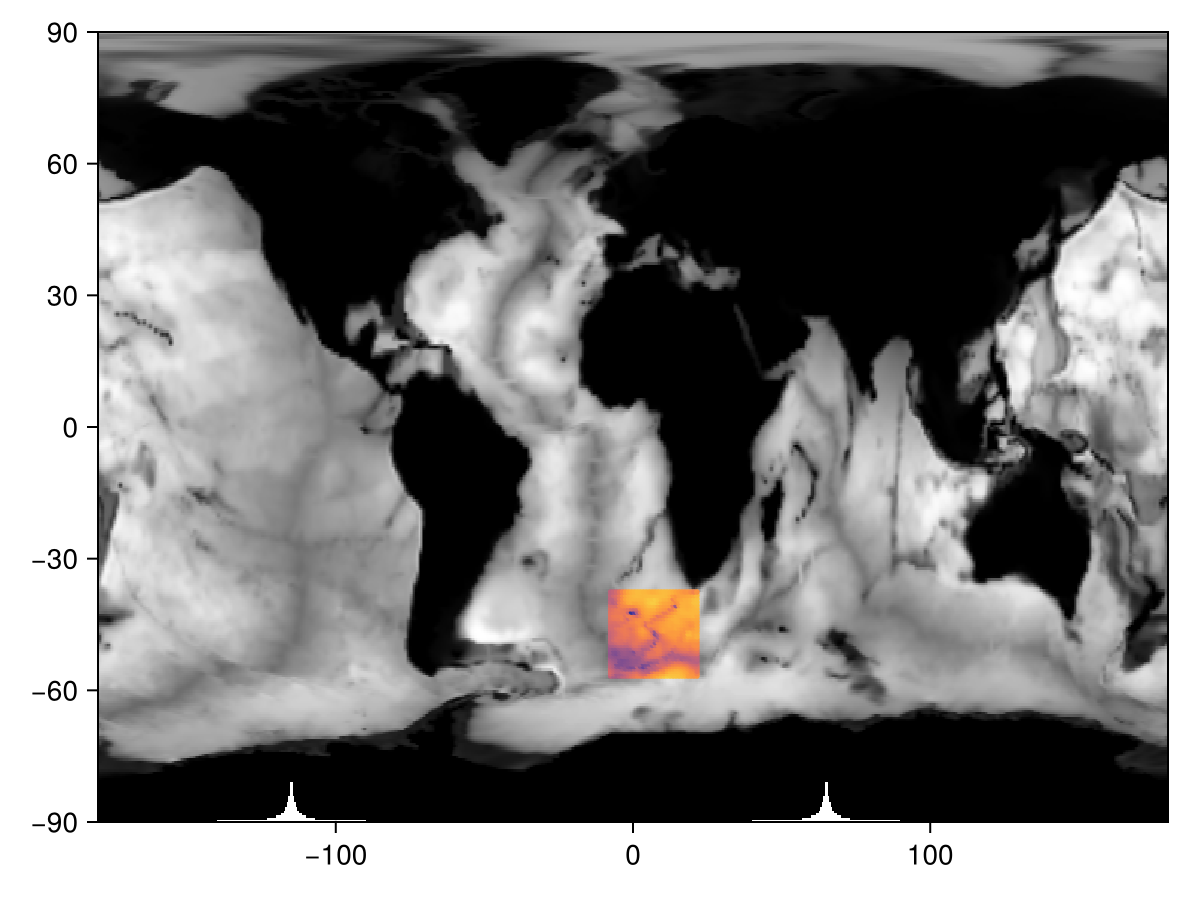

In [8]:
mm=Int(round(size(Γ.XC[3],1)/nn))
oo=Int(floor(mm*mm*13/10))
ii=(1:mm*mm*13)[oo]

fig_tile=heatmap(Γ.Depth,interpolation=λ,colormap=:grayC,colorbar=false)
scatter!(current_axis(),XC_tiled[ii][:],YC_tiled[ii][:],color=Depth_tiled[ii][:],
        markersize=4.0,colormap=:thermal,colorrange=(0.0,6000.0))
fig_tile

## LLC90 Grid Faces

These are the larger areas that MITgcm defines. Tiles are chunks of faces.

In [ ]:
faceID=3
fig_area=scatter(Γ.XC,Γ.YC,color=:black,markersize=2.0,)
MS=log10.(Γ.RAC)*μ
scatter!(current_axis(),Γ.XC[faceID][:],Γ.YC[faceID][:],color=MS[faceID][:],
            colorrange = (8.8,10.2),markersize=3.0,colormap=:thermal)
fig_area

## Calculating transports between two end-points

In [ ]:
lon1=20.0; lon2=-63.0; lat1=-20.0; lat2=-66.0
lons=[lon1 lon2]; lats=[lat1 lat2]
my_section=demo.one_section(Γ,lons,lats)

fig_section=heatmap(λ.μ*Γ.Depth,interpolation=λ,colormap=:spring)
ax=current_axis(fig_section)
scatter!(ax,my_section.lon[:],my_section.lat[:],color=:blue,markersize=2.0)
scatter!(ax,my_section.lon[:],my_section.lat[:],color=:black,markersize=4.0)
scatter!(ax,lons[:],lats[:],color=:blue)
fig_section

## Regional Masks

There are many ways to split up the global domain into Oceans, Seas, etc. Here is one example.

In [ ]:
basin_ID=1
jj=findall(basins.mask.==basin_ID)
fig_basins=scatter(Γ.XC,Γ.YC,color=basins.mask*μ,colormap=:lisbon,markersize=3.0)
[scatter!(current_axis(),Γ.XC[jj][k],Γ.YC[jj][k],color=:red,markersize=3) for k in 1:length(jj)] 
fig_basins

## Polygons on Maps

In [ ]:
source=[:shp_example,:json_example][1]
lon0=-160.0
"[done] set parameters for plots"

In [ ]:
if source==:shp_example
    fil=demo.download_polygons("ne_110m_admin_0_countries.shp")
elseif source==:json_example
    fil=demo.download_polygons("countries.geojson")
end
pol=MeshArrays.read_polygons(fil)
"Done With Reading Country Polygons"

In [ ]:
fig_polygons=Figure()
ax1=Axis(fig_polygons[1,1])
[lines!(ax1,l1,color = :black, linewidth = 0.5) for l1 in pol]
fig_polygons

## Geographic Projection

In [ ]:
meta=(colorrange=(0.0,6000.0),cmap=:berlin,gridcolor=:lightgreen,ttl="Ocean Depth (m)")
data=(lon=λ.lon,lat=λ.lat,var=Depth_interpolated,meta=meta,polygons=pol)

proj_ID=1
proj_name=["wintri","natearth2","longlat"]
proj=Proj.Transformation(MA_preset=proj_ID,lon0=lon0)

fig0=let
    f = Figure()
    ax = f[1, 1] = Axis(f, aspect = DataAspect(), title = "Ocean Depth (m)")
    
    pr_ax=MeshArrays.ProjAxis(ax; proj=proj,lon0=lon0)
    
    surf = surface!(pr_ax,λ.lon,λ.lat,0*λ.lat; color=Depth_interpolated, 
            colorrange=(0.0,6000.0), colormap=:berlin, shading = NoShading)
    lines!(pr_ax; polygons=pol,color=:black,linewidth=0.5)
    #y1=-90:5:90; x1=lon0.+0*y1; scatter!(pr_ax,x1,y1,color=:yellow,markersize=5,marker=:x)
    MeshArrays.grid_lines!(pr_ax;color=:lightgreen,linewidth=0.5)
    
    Colorbar(f[1,2], surf, height = Relative(0.5))
    f
end

## Zonal Averaging Detail

In [ ]:
LC=LatitudeCircles(79.0,Γ)
aa=LC.C
locClat=( lon=[Γ.XC[aa[i,1]][aa[i,2],aa[i,3]] for i in 1:size(aa,1)],
            lat=[Γ.YC[aa[i,1]][aa[i,2],aa[i,3]] for i in 1:size(aa,1)])
"Done with latitude line"

## Interpolation Scheme Detail

Wondering about the Interpolation Code? Let's Break It Down:

- find nearest neighbor (`MeshArray` & `set`)
- define subdomain tiles (`MeshArray` -> `tiles`)
- exchange and start loop (`tile` & `subset`)
    - local stereographic projection
    - define array of quadrilaterals
    - find enclosing quadrilaterals
    - compute interpolation coefficients

In [ ]:
(fig1,fig2,fig3)=MeshArrays.plot_examples(:interpolation_demo,Γ);